In [18]:
# 1. Setup and data loading

# 1.1 Install and import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression

In [19]:
# 1.2 Load the diabetes dataset

# Load dataset as a pandas DataFrame
diabetes = load_diabetes(as_frame=True)  # returns data + target as DataFrame/Series[web:44][web:41]

# Features (10 numeric columns) and target (disease progression)[web:40][web:46]
data_df = diabetes.data        # shape (442, 10)[web:44]
target = diabetes.target       # shape (442,)[web:44]

print(data_df.head())
print("\nTarget head:\n", target.head())
print("\nData shape:", data_df.shape)
print("Target shape:", target.shape)

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  

Target head:
 0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

Data shape: (442, 10)
Target shape: (442,)


In [20]:
# 1.3 Select feature and target

# Use **BMI** as the single feature $x$ and disease progression as $y$. 
# [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/sklearn-diabetes-dataset/)

# Select one feature: body mass index (bmi)
x = data_df["bmi"].values      # shape (442,)
y = target.values              # shape (442,)

print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (442,)
y shape: (442,)


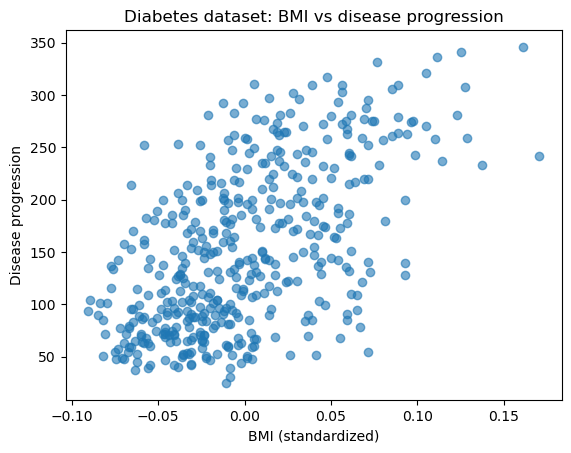

In [21]:
# 1.4 Visualize the relationship

plt.scatter(x, y, alpha=0.6)
plt.xlabel("BMI (standardized)")
plt.ylabel("Disease progression")
plt.title("Diabetes dataset: BMI vs disease progression")
plt.show()

#### 2. Define model and MSE loss

The model is $\hat{y}_i = \theta_0 x_i$ (no intercept).

In [22]:
# 2.1 Prediction function

def predict(theta0, x):
    """
    Compute predictions y_hat = theta0 * x
    x: 1D array
    theta0: scalar
    """
    return theta0 * x

2.2 Mean Squared Error (MSE) function

$$
\text{MSE}(\theta_0) = \frac{1}{n} \sum_{i=1}^{n} (\theta_0 x_i - y_i)^2
$$


In [23]:
def mse_loss(theta0, x, y):
    """
    Mean squared error for model y_hat = theta0 * x
    """
    y_hat = predict(theta0, x)
    return np.mean((y_hat - y) ** 2)

In [24]:
# 2.3 Try a few $\theta_0$ values

for theta0_try in [0.0, 0.01, 0.1, 0.2]:
    loss = mse_loss(theta0_try, x, y)
    print(f"theta0={theta0_try:.3f} -> MSE={loss:.4f}")

theta0=0.000 -> MSE=29074.4819
theta0=0.010 -> MSE=29074.4389
theta0=0.100 -> MSE=29074.0523
theta0=0.200 -> MSE=29073.6228


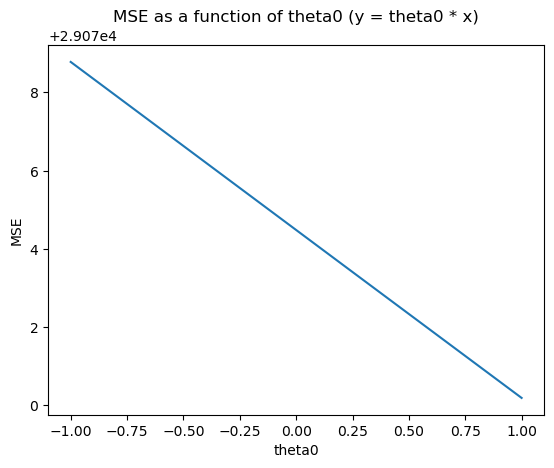

In [25]:
# Optional: plot MSE as a function of $\theta_0$:

theta_grid = np.linspace(-1.0, 1.0, 200)
loss_values = [mse_loss(t, x, y) for t in theta_grid]

plt.plot(theta_grid, loss_values)
plt.xlabel("theta0")
plt.ylabel("MSE")
plt.title("MSE as a function of theta0 (y = theta0 * x)")
plt.show()

#### 3. Derive and implement the gradient

For  
$$
\text{MSE}(\theta_0) = \frac{1}{n} \sum_{i=1}^{n} (\theta_0 x_i - y_i)^2,
$$  
the derivative w.r.t. $\theta_0$ is  
$$
\frac{d}{d\theta_0}\text{MSE}(\theta_0) = \frac{2}{n} \sum_{i=1}^{n} (\theta_0 x_i - y_i) x_i.
$$

3.1 Gradient function


In [26]:
def mse_grad(theta0, x, y):
    """
    Gradient of the MSE with respect to theta0.
    """
    n = len(x)
    y_hat = predict(theta0, x)
    grad = (2.0 / n) * np.sum((y_hat - y) * x)
    return grad

In [27]:
# 3.2 Inspect gradient sign

for theta0_try in [0.0, 0.1, 0.2]:
    grad = mse_grad(theta0_try, x, y)
    print(f"theta0={theta0_try:.3f} -> gradient={grad:.4f}")

theta0=0.000 -> gradient=-4.2961
theta0=0.100 -> gradient=-4.2956
theta0=0.200 -> gradient=-4.2952


Interpretation:

- If gradient > 0, gradient descent will move $\theta_0$ **downward** (subtract a positive number) to reduce loss.  
- If gradient < 0, gradient descent will move $\theta_0$ **upward** to reduce loss.

#### 4. Implement gradient descent

Standard update rule:

$$
\theta_0^{(k+1)} = \theta_0^{(k)} - \text{lr} \cdot \frac{d}{d\theta_0} \text{MSE}(\theta_0^{(k)}).
$$

4.1 Gradient descent function

In [28]:
def gradient_descent(theta0_init, x, y, lr, n_steps):
    """
    Run gradient descent on theta0 for model y = theta0 * x.

    Returns:
        thetas: np.array of shape (n_steps + 1,)
                sequence of theta0 values over iterations
        losses: np.array of shape (n_steps + 1,)
                MSE at each theta0
    """
    thetas = [theta0_init]
    losses = [mse_loss(theta0_init, x, y)]
    
    theta = theta0_init
    for _ in range(n_steps):
        grad = mse_grad(theta, x, y)
        theta = theta - lr * grad
        thetas.append(theta)
        losses.append(mse_loss(theta, x, y))
    
    return np.array(thetas), np.array(losses)

In [29]:
# 4.2 Run gradient descent

theta0_init = 0.0
learning_rate = 0.01
n_steps = 100

thetas, losses = gradient_descent(theta0_init, x, y, learning_rate, n_steps)

print("First 10 theta0 values:\n", thetas[:10])
print("\nLast 5 theta0 values:\n", thetas[-5:])
print("\nFinal theta0:", thetas[-1])
print("Final MSE:", losses[-1])

First 10 theta0 values:
 [0.         0.04296087 0.0859198  0.12887678 0.17183182 0.21478492
 0.25773607 0.30068528 0.34363255 0.38657787]

Last 5 theta0 values:
 [4.1153919  4.15816655 4.20093927 4.24371005 4.2864789 ]

Final theta0: 4.286478901060055
Final MSE: 29056.108383434963


#### 5. Visualize convergence

5.1 $\theta_0$ over iterations

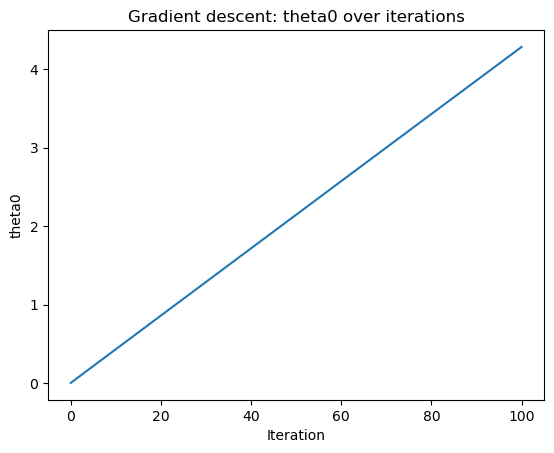

In [30]:
plt.plot(thetas)
plt.xlabel("Iteration")
plt.ylabel("theta0")
plt.title("Gradient descent: theta0 over iterations")
plt.show()

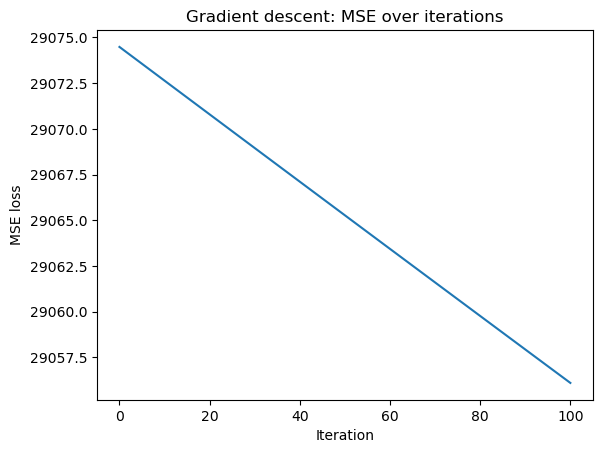

In [31]:
# 5.2 Loss over iterations

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.title("Gradient descent: MSE over iterations")
plt.show()

You should see:

- $\theta_0$ values stabilizing over time.  
- MSE decreasing and flattening out as iterations increase.

#### 6. Compare with scikit‑learn’s solution

Now fit a linear model with **no intercept** using the same feature and target. [codecademy](https://www.codecademy.com/article/linear-regression-with-scikit-learn-a-step-by-step-guide-using-python) 

In [32]:
# 6.1 Prepare feature matrix

# scikit-learn expects 2D feature matrix
X = x.reshape(-1, 1)
y_vec = y  # already 1D

In [33]:
# 6.2 Fit LinearRegression (no intercept)

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X, y_vec)

theta0_sklearn = linreg.coef_[0]
print("theta0 from scikit-learn:", theta0_sklearn)

theta0 from scikit-learn: 949.4352603840236


In [34]:
# 6.3 Compare values
theta0_gd = thetas[-1]

print("Gradient descent theta0:", theta0_gd)
print("scikit-learn theta0   :", theta0_sklearn)
print("Absolute difference   :", abs(theta0_gd - theta0_sklearn))

# $\theta_0$ from gradient descent is close to $\theta_0$ from scikit‑learn’s closed‑form solver.


Gradient descent theta0: 4.286478901060055
scikit-learn theta0   : 949.4352603840236
Absolute difference   : 945.1487814829636


In [35]:
# 7. Experiment with learning rates
# Try different `learning_rate` values:

for lr in [0.001, 0.01, 0.1]:
    thetas_lr, losses_lr = gradient_descent(theta0_init=0.0, x=x, y=y, lr=lr, n_steps=100)
    print(f"\nLearning rate = {lr}")
    print("  Final theta0:", thetas_lr[-1])
    print("  Final MSE   :", losses_lr[-1])



Learning rate = 0.001
  Final theta0: 0.4295125047511125
  Final MSE   : 29072.63709467742

Learning rate = 0.01
  Final theta0: 4.286478901060055
  Final MSE   : 29056.108383434963

Learning rate = 0.1
  Final theta0: 42.01269426329591
  Final MSE   : 28897.985067521826
